<a href="https://colab.research.google.com/github/natashabutt/TwitterAirlineULMFiT/blob/master/ULMFiT_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Twitter US Airline Sentiment Analysis Using ULMFiT

In this notebook, we perform sentiment analysis on [Twitter US airline data](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) using Universal Language Model Fine-tuning for Text Classification ([ULMFiT](https://arxiv.org/pdf/1801.06146.pdf)) and achieving a test accuracy of 84%. For our ULMFiT implementation, we use the [fastai library](https://nlp.fast.ai/category/classification.html) for preprocessing our data, fine-tuning a pretrained language model and building our sentiment classifier. The language model (LM) is an English model with an AWD-LSTM architecture pre-trained by fast.ai on [Wikitext-103](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/). The structure of this notebook is as follows:


1. Set up environment
2. Preprocess airline data
3. Fine-tune pretrained LM
4. Build sentiment classifier
5. Predictions



## 1. Set up environment

Install fastai library if necessary by uncommenting line below

In [ ]:
# % pip install fastai

Import packages

In [1]:
from fastai.text import *
from google.colab import drive
import pandas as pd

## 2. Preprocess airline data

The data has been copied to a shared [google drive folder](https://drive.google.com/drive/folders/11FxkhoXSUcn5stuwh9eslLpvOGoaW4Jt?usp=sharing). This means we can now mount the drive and access the data in colab.

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Define the path where the airline data is saved.

In [3]:
data_path = '/content/drive/My Drive/ULMFiT Sentiment/'

Shuffle the tweet data and split into training and test sets.

In [4]:
tweets = pd.read_csv('{}Tweets.csv'.format(data_path)) # read csv to pandas dataframe
tweets = tweets.sample(frac=1).reset_index(drop=True) # shuffle
len_train = round(0.9*len(tweets)) # length of training set
len_test = len(tweets) - len_train # length of test set
tweets.iloc[:len_train,:].to_csv('{}train.csv'.format(data_path)) # save train to csv
tweets.iloc[len_train:,:].to_csv('{}test.csv'.format(data_path)) # save test to csv
print('no. of tweets: {} train size: {} test size: {}'.format(len(tweets),len_train,len_test))

no. of tweets: 14640 train size: 13176 test size: 1464


Fastai has a [default Spacy tokeniser](https://docs.fast.ai/text.transform.html#BaseTokenizer) for preprocessing. We notice that this includes adding spaces around '#' so that '#donaldtrump' would become ' # donald trump'. However, this rule does not add space around '@'. This is not ideal for tweets and so we will create a customised tokeniser with the fastai defaults plus a new pre rule for adding space around '@'.

In [5]:
def spec_add_spaces_at(t):
    "Add spaces around @"
    return re.sub(r'([@])', r' \1 ', t)

In [6]:
print(spec_add_spaces_at('@donaldtrump'))

 @ donaldtrump


In [7]:
tokenizer = Tokenizer(pre_rules=[fix_html, replace_rep, replace_wrep, spec_add_spaces, rm_useless_spaces, spec_add_spaces_at])
tok = SpacyTokenizer('en')

In [8]:
tokenizer.process_text('@donaldtrump', tok)

[' ', '@', 'donaldtrump']

Create a TextDataBunch for the language model, passing our tokenizer to preprocess the data.

In [9]:
data_lm = TextLMDataBunch.from_csv(data_path, 'train.csv', text_cols = 'text', label_cols = 'airline_sentiment', tokenizer=tokenizer)

In [10]:
data_lm.show_batch()

idx,text
0,@ southwestair are you guys alive ? i 've been on hold for 25 minutes and counting xxrep 5 . xxbos @ jetblue just lost very loyal customers who use them 4 - 10 times a year . xxbos @ usairways need to retrain xxup us xxunk lead flight attendant and gate agent at arrival xxup mke 2 / 23 . xxmaj horrible attitudes toward helping
1,"on time , but we should of been off the ground 15 minutes ago . xxbos @ xxmaj united ticket counter xxmaj masters out of xxup smf not very helpful . xxbos @ virginamerica xxmaj very poor experience . xxmaj first computer problem now seat malfunction . xxmaj stuck . xxmaj missing meeting in xxmaj san xxmaj diego . xxbos @ united boarding a"
2,the extra xxunk i 'm carrying it on 😒 xxbos @ united xxmaj flight xxunk ( xxup xxunk ) arrives at @ flytpa following flight from @ iah http : / / t.co / xxunk xxbos @ united what did you do with my seat . xxmaj international connection . xxmaj seriously ? xxbos @ virginamerica thank you ! i
3,"and it 's not even snowing in xxup fl . xxbos xxmaj first base already ? i like your style @ jetblue xxbos @ jetblue , was far less painful than what was coming from xxmaj avis . 💙 xxbos @ usairways please follow me so i can xxup dm you about something xxbos @ southwestair xxmaj finally ! xxmaj integration w"
4,@ southwestair think you need to follow me for a xxup dm xxbos @ southwestair could you please tell me if there is a way to add a xxup rr # to a flight that already took place ? xxbos @ usairways shout out to the pilots and xxup fc xxunk ) of xxup us xxunk . xxmaj super strong xxunk during landing .


Create TextDataBunch for the classification model, passing our tokenizer to preprocess the data and the vocab from our language model.

In [11]:
data_clas = TextClasDataBunch.from_csv(data_path, 'train.csv', text_cols = 'text', test='test.csv', label_cols = 'airline_sentiment', tokenizer=tokenizer, vocab=data_lm.train_ds.vocab, bs=32)

In [12]:
print('classes: {}'.format(data_clas.classes))

classes: ['negative', 'neutral', 'positive']


In [13]:
data_clas.show_batch()

text,target
xxbos @ united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @ united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
"xxbos @ united xxmaj waiting for xxunk xxup ewr - xxup ord , delayed xxunk mins . xxmaj might miss xxunk xxup ord - xxup xxunk at 6 pm xxup xxunk . xxmaj any room on xxunk xxup ord - xxup xxunk in case i miss xxunk ?",negative
"xxbos @ southwestair xxmaj loved one 's flight xxup atl to xxup ind xxmaj cancelled xxmaj flightled due to "" ice in xxmaj xxunk "" . xxmaj sitting here in xxmaj xxunk , it is xxunk dry . xxmaj tomorrow 4 - 6 "" of snow .",negative
"xxbos @ americanair my wife was on a flt from xxup bro to xxup tul via xxup dfw that was xxmaj cancelled xxmaj flighted . xxmaj bought an xxup swa flight to get her home . xxmaj partial refund , xxup dm me plz ?",negative


Inspect the vocabulary.

In [14]:
print('length of vocab: {}'.format(len(data_lm.train_ds.vocab.itos)))

length of vocab: 5552


In [15]:
data_lm.train_ds.vocab.stoi.items()

dict_items([('xxunk', 0), ('xxpad', 1), ('xxbos', 2), ('xxeos', 3), ('xxfld', 4), ('xxmaj', 5), ('xxup', 6), ('xxrep', 7), ('xxwrep', 8), ('@', 9), (' ', 10), ('.', 11), ('to', 12), ('i', 13), ('the', 14), ('!', 15), ('a', 16), ('?', 17), ('you', 18), ('/', 19), ('united', 20), (',', 21), ('for', 22), ('flight', 23), ('on', 24), ('#', 25), ('and', 26), ('my', 27), ('americanair', 28), ('usairways', 29), ('is', 30), ('in', 31), ('jetblue', 32), ('it', 33), ('southwestair', 34), ('of', 35), ("n't", 36), ('me', 37), (':', 38), ('your', 39), ('have', 40), ('that', 41), ('was', 42), ('not', 43), ('at', 44), ('with', 45), ('no', 46), ("'s", 47), ('-', 48), ('this', 49), ('do', 50), ('get', 51), ('&', 52), ('we', 53), ('but', 54), ('be', 55), ('t.co', 56), ('from', 57), ('are', 58), ('can', 59), ('http', 60), ('thanks', 61), ('cancelled', 62), ('an', 63), ('now', 64), ('service', 65), ('just', 66), ('"', 67), ('so', 68), ('been', 69), ('...', 70), ('help', 71), ('what', 72), ('2', 73), ('time

##3. Fine-tune pretrained LM

Call the fastai's language_model_learner on our airline data with AWD_LSTM architechure and pretrained weights. We choose dropout < 1 to reduce underfitting.

In [16]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=True)

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


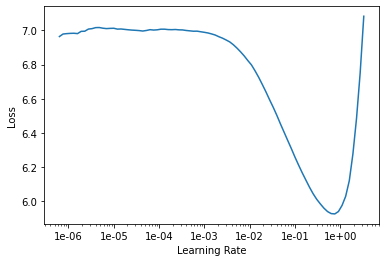

In [18]:
learn.recorder.plot()

To optimise the learning rate, we follow the [one cycle policy](https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?). We initially train the final layer and then unfreeze to train entire model.

In [19]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.293869,3.651074,0.315374,00:22


In [20]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


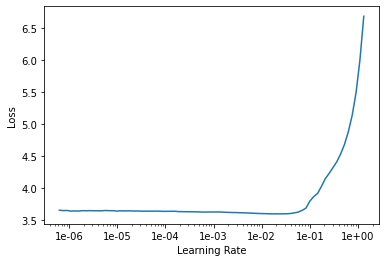

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.551591,3.475408,0.338295,00:28
1,3.331598,3.360199,0.353376,00:28
2,2.829446,3.399121,0.355273,00:28


Now our LM is fine-tuned using the airline data, test our model by predicting the next ten words given a new phrase.

In [24]:
learn.predict("The flight was awful. They lost my", n_words=10)

'The flight was awful. They lost my luggage . But it really good for me to'

Although it does not make much sense, the sentence does respect basic grammer. We also note that this phrase "CancelledFlightled" comes up in a lot of the tweets in the raw data file which is strange as it appears to be a typo.

In [25]:
learn.save_encoder('ft_enc')

## 4. Build sentiment classifier 

Call the fastai's text_classifier_learner on our airline data with AWD_LSTM architechure and pretrained weights.

In [71]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [72]:
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (10540 items)
x: TextList
xxbos   @ jetblue y u xxup no xxup let xxup me xxup out xxup and xxup make xxup fun xxup size xxup cookies # xxunk # xxunk # xxunk,xxbos   @ united thank you ! xxmaj my second flight i already got bumped up to 1st ! xxmaj love it !,xxbos   @ southwestair xxmaj my flight to xxup kc has been xxmaj cancelled xxmaj flighted and the next available is n't till xxmaj tuesday ? ! xxmaj what am i supposed to do for 3 nights xxrep 5 ?,xxbos   @ united no my concerns were not addressed,xxbos   @ southwestair i changed my flight through xxmaj st. xxmaj louis . xxmaj thanks for the reply though !
y: CategoryList
negative,positive,negative,negative,positive
Path: /content/drive/My Drive/ULMFiT Sentiment;

Valid: LabelList (2636 items)
x: TextList
xxbos   @ southwestair xxmaj on hold for 45 minutes trying to rebook a xxmaj cancelled xxmaj flightled flight with a companion ticket . xxmaj help ?,xxbos   @ usairways i did n't

In [73]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


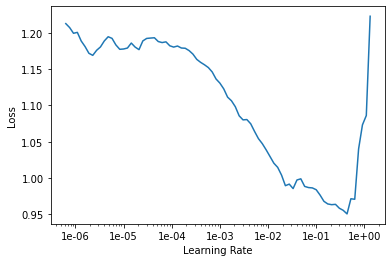

In [74]:
learn.recorder.plot()

Again, we follow the [one cycle policy](https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?) and initially train the final layer followed by the entire model.

In [75]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.603808,0.500849,0.799317,00:20


In [76]:
learn.unfreeze()

In [84]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


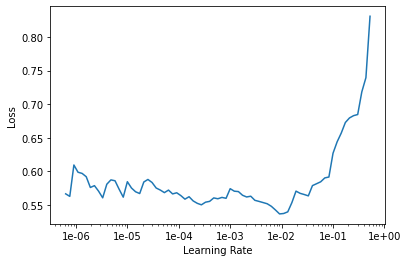

In [85]:
learn.recorder.plot()

In [86]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.529447,0.434281,0.830425,00:49
1,0.398124,0.429089,0.830046,00:45


## 5. Predictions

### New phrases

Make up some phrases about flying and predict the sentiment.

In [87]:
learn.predict("It was a good flight")

(Category tensor(2), tensor(2), tensor([0.0605, 0.0207, 0.9188]))

In [88]:
learn.predict("It was a flight")

(Category tensor(0), tensor(0), tensor([0.3849, 0.2957, 0.3194]))

In [89]:
learn.predict("It was a bad flight")

(Category tensor(0), tensor(0), tensor([0.5881, 0.0499, 0.3621]))

### Validation Set

Predict for the validation set.

In [90]:
val_pred, val_target, val_loss = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

In [91]:
valid_results = pd.DataFrame({'target' : val_target.numpy(),'negative prob':val_pred.numpy()[:,0],'neutral prob':val_pred.numpy()[:,1],'positive prob':val_pred.numpy()[:,2],'losses' : val_loss.numpy()})
valid_results

,target,negative prob,neutral prob,positive prob,losses
0,0,0.953540,0.037645,0.008815,0.047573
1,0,0.838979,0.154967,0.006054,0.175570
2,1,0.697113,0.171303,0.131584,1.764320
3,0,0.796035,0.131438,0.072527,0.228113
4,0,0.686435,0.293711,0.019853,0.376243
...,...,...,...,...,...
2631,0,0.053009,0.938781,0.008209,2.937294
2632,1,0.244610,0.746193,0.009198,0.292772
2633,2,0.005636,0.010104,0.984260,0.015866
2634,0,0.793781,0.123051,0.083168,0.230947


Take a closer look at the predictions with the biggest losses.

In [92]:
txt_ci = TextClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"xxbos @ americanair @ robertdwyer xxup aa does nt charge any fees to change award tickets as long as the origin , destination & & award type remains the same",neutral,positive,7.02,0.00
xxbos @ united flight 1491 ... plane from xxup sfo to xxup den is basically on time .,negative,positive,5.78,0.00
"xxbos @ virginamerica @ ladygaga @ carrieunderwood all are great , but i have to go with # carrieunderwood 😍 👌",positive,neutral,5.21,0.01
xxbos @ usairways over the phone . i called the xxunk number and she picked up almost immediately .,negative,positive,4.98,0.01
xxbos @ jetblue 's xxup ceo battles to appease passengers and xxmaj wall xxmaj street - @ thevdt http : / / t.co / xxunk,neutral,negative,4.90,0.01


### Test Set

Predict for our test set and calculate accuracy.

In [93]:
test_data = pd.read_csv('{}test.csv'.format(data_path))

test_pred, test_target, test_loss = learn.get_preds(ds_type=DatasetType.Test, with_loss=True,ordered=True)

test_results = pd.DataFrame({'negative':test_pred.numpy()[:,0],'neutral':test_pred.numpy()[:,1],'positive':test_pred.numpy()[:,2]})
test_results['pred'] = test_results.idxmax(axis=1)

test_data = pd.concat([tweets.iloc[len_train:,:].reset_index(drop=True),test_results], axis=1, sort=False)
test_data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,negative,neutral,positive,pred
0,567969159927205888,negative,1.0000,Customer Service Issue,1.0000,United,NaN,MickGriffin,NaN,0,@united submitted customer care form Jan 7th. ...,NaN,2015-02-18 00:49:34 -0800,Gdansk / Manchester,London,0.973677,0.025642,0.000681,negative
1,570284129138274304,positive,1.0000,NaN,NaN,Southwest,NaN,catjubs,NaN,0,@SouthwestAir THANK YOU for your awesome flig...,NaN,2015-02-24 10:08:26 -0800,lurking in a coffeehouse,Pacific Time (US & Canada),0.164566,0.008399,0.827035,positive
2,568888806805512192,positive,0.6715,NaN,NaN,Southwest,NaN,Joeanhalt,NaN,0,@SouthwestAir rules.,"[41.78959656, -87.74028015]",2015-02-20 13:43:55 -0800,"chicago, il",Central Time (US & Canada),0.112247,0.784684,0.103068,neutral
3,568804253151731712,negative,1.0000,Bad Flight,1.0000,United,NaN,blastedgtl,NaN,0,@united new flight has me at the window. Kind ...,NaN,2015-02-20 08:07:56 -0800,NaN,Quito,0.955373,0.015131,0.029496,negative
4,569644171331538945,negative,1.0000,Bad Flight,0.3556,United,NaN,mamijeanna,NaN,0,@united seriously? 45 min on the plane at bhm ...,NaN,2015-02-22 15:45:28 -0800,NaN,NaN,0.982424,0.016931,0.000645,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,569252529596297217,negative,1.0000,Customer Service Issue,0.6822,Southwest,NaN,abbeymcole,NaN,0,@SouthwestAir officially on hold for 2 hours!,NaN,2015-02-21 13:49:13 -0800,Kansas City,Central Time (US & Canada),0.981741,0.010265,0.007994,negative
1460,568189949415170048,negative,1.0000,Lost Luggage,1.0000,United,NaN,mtezna,NaN,0,@united Not sure what happened @ MSP yesterday...,NaN,2015-02-18 15:26:55 -0800,Virginia,Eastern Time (US & Canada),0.958779,0.019483,0.021737,negative
1461,569185594095509504,negative,1.0000,Bad Flight,0.6787,United,NaN,iamlaurencard,NaN,1,.@united too much info to share via tweet. Ple...,NaN,2015-02-21 09:23:15 -0800,"Aliso Viejo, CA",Pacific Time (US & Canada),0.738638,0.107102,0.154260,negative
1462,568781747128803328,positive,1.0000,NaN,NaN,Southwest,NaN,svssywentz,NaN,0,"@SouthwestAir i live in the southwest, Imagine...",NaN,2015-02-20 06:38:30 -0800,NaN,NaN,0.001941,0.047042,0.951017,positive


In [94]:
accuracy = np.mean(test_data['airline_sentiment']==test_data['pred'])
print('test accuracy: {}'.format(round(accuracy,3)))

test accuracy: 0.84
